In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import Tensor
from torch.nn import functional

from train import Mode, ModelManager
from utils import plot_img_and_top, get_loader, get_cifar10

# globals
NUM_CLASSES = 10
BATCH_SIZE = 25
NUM_TRAIN = 50000
NUM_TEST = 10000
PRUNE_EPOCHS = 6

NOTEBOOK_NAME = 'flip_cifar10'
# PATH_NOTEBOOK_SAVED_DATA = os.path.join(DIR_ROOT_SAVE, NOTEBOOK_NAME, 'general.pt')

print('train on:', ModelManager.DEVICE)

train_idx = np.arange(NUM_TRAIN, dtype=int)
test_idx = np.arange(NUM_TEST, dtype=int)
dataset_train, dataset_test, dataset_train_for_test, dataset_train_raw = get_cifar10()
loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE, shuffle=True)
loader_test = get_loader(dataset_test, test_idx, BATCH_SIZE, shuffle=False)
loader_train_ordered = get_loader(dataset_train_for_test, train_idx, BATCH_SIZE, shuffle=False)
Y_train = Tensor(dataset_train.targets)[train_idx].type(torch.int64)
Y_test = Tensor(dataset_test.targets)[test_idx].type(torch.int64)

train on: cuda
Files already downloaded and verified
Files already downloaded and verified


In [2]:
epochs_pred = torch.empty((PRUNE_EPOCHS, NUM_TRAIN), dtype=torch.int8)
change_counter = torch.zeros(NUM_TRAIN, dtype=torch.int8)

model_manager = ModelManager(NUM_CLASSES, model_name='model', dir_=NOTEBOOK_NAME, load=False)
loss_train, loss_valid, acc_train, acc_valid = [], [], [], []
model_manager.model.to(ModelManager.DEVICE)
for epoch in range(PRUNE_EPOCHS):
    # print('=======epoch============')
    model_manager.model.to(ModelManager.DEVICE)
    train_res = model_manager.run_epoch(loader_train, Mode.TRAIN)
    valid_res = model_manager.run_epoch(loader_test, Mode.VALIDATE)
    loss_train.append(train_res[2]), loss_valid.append(valid_res[2])
    acc_train.append(train_res[3]), acc_valid.append(valid_res[3])
    s = f'Epoch: {epoch} Training: Loss: {loss_train[-1]:.6f} Acc: {acc_train[-1]:.6f}  ' \
        f'Validation Loss: {loss_valid[-1]:.6f} Acc: {acc_valid[-1]:.6f}  '

    train_res = model_manager.run_epoch(loader_train_ordered, Mode.TEST)
    epochs_pred[epoch] = train_res[1].detach().clone()
    # print(epochs_pred[epoch] == Y_train)
    # print(epochs_pred[epoch])
    # print(Y_train)
    if epoch:
        changes = torch.Tensor(epochs_pred[epoch - 1] != epochs_pred[epoch])
        changes_mean = changes.type(torch.float64).mean()
        model_manager.tb.add_scalar('changes_mean', changes_mean, epoch)
        change_counter += changes
        s += f'Changes {changes_mean:.2%}'

    print(s), model_manager.model.cpu()
    model_manager.epochs += 1
    # model_manager.scheduler.step()

model_manager.save_model()
model_manager.data['train']['loss'] += loss_train
model_manager.data['train']['acc'] += acc_train
model_manager.data['valid']['loss'] += loss_valid
model_manager.data['valid']['acc'] += acc_valid
model_manager.save_data(data_other={'epochs_pred': epochs_pred, 'change_counter': change_counter})

Epoch: 0 Training: Loss: 0.058009 Acc: 0.469140  Validation Loss: 0.042944 Acc: 0.619800                                                     
Epoch: 1 Training: Loss: 0.041764 Acc: 0.631200  Validation Loss: 0.032186 Acc: 0.722600  Changes 32.96%                                      
Epoch: 2 Training: Loss: 0.033860 Acc: 0.703080  Validation Loss: 0.028402 Acc: 0.750800  Changes 23.30%                                      
Epoch: 3 Training: Loss: 0.028684 Acc: 0.748980  Validation Loss: 0.023711 Acc: 0.801000  Changes 23.23%                                      
Epoch: 4 Training: Loss: 0.025671 Acc: 0.777500  Validation Loss: 0.020082 Acc: 0.830900  Changes 15.00%                                      
Epoch: 5 Training: Loss: 0.022943 Acc: 0.800600  Validation Loss: 0.020921 Acc: 0.819600  Changes 15.45%                                      


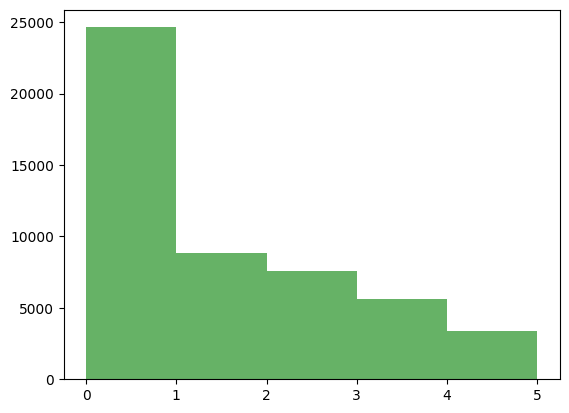

In [2]:
model_manager = ModelManager(NUM_CLASSES, model_name='model', dir_=NOTEBOOK_NAME, load=True)
# print(model_manager.data_other.keys())
change_counter = model_manager.data_other['change_counter']
epochs_pred = model_manager.data_other['epochs_pred']
true_forget = model_manager.data_other['true_forget']


# s, e = 200, 205
# print(epochs_pred[:, s:e])
# print(epochs_pred[:, s:e] == Y_train[s:e])
# print(Y_train[s:e])
# # print(change_counter[:5])
#
#
# print(true_forget[s:e])
plt.hist(change_counter, bins=np.arange(PRUNE_EPOCHS), facecolor='g', alpha=0.6)
plt.show()

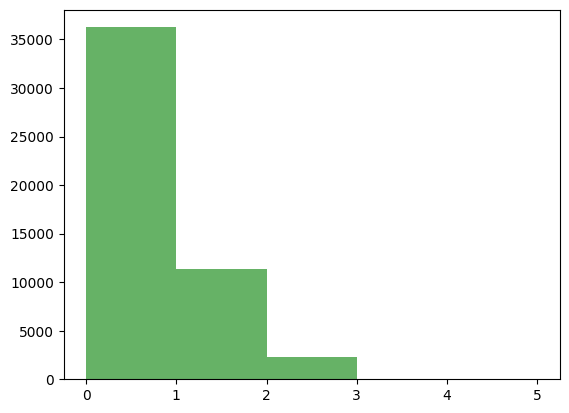

In [3]:
# epochs_pred_bool = epochs_pred == Y_train
# true_forget = torch.zeros(NUM_TRAIN, dtype=torch.int8)
# for i in range(1, PRUNE_EPOCHS):
#     true_forget += (epochs_pred_bool[i - 1] & (~epochs_pred_bool[i]))
# model_manager.save_data(data_other={'true_forget': true_forget})

plt.hist(true_forget, bins=np.arange(PRUNE_EPOCHS), facecolor='g', alpha=0.6)
plt.show()

In [4]:
model_manager.model.to(ModelManager.DEVICE)
scores, _, _, _ = model_manager.run_epoch(loader_train_ordered, mode=Mode.TEST)
model_manager.model.cpu()
scores = scores.cpu()

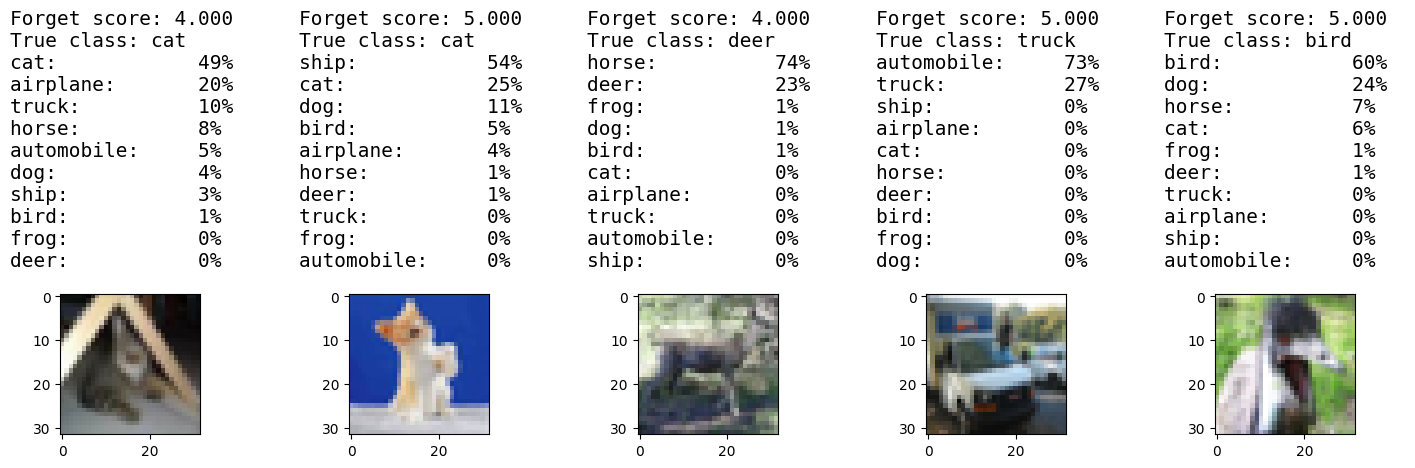

In [8]:


plot_img_and_top(dataset_train_raw, (.98, 1.), change_counter, functional.softmax(scores, dim=1), score_name='Flip')

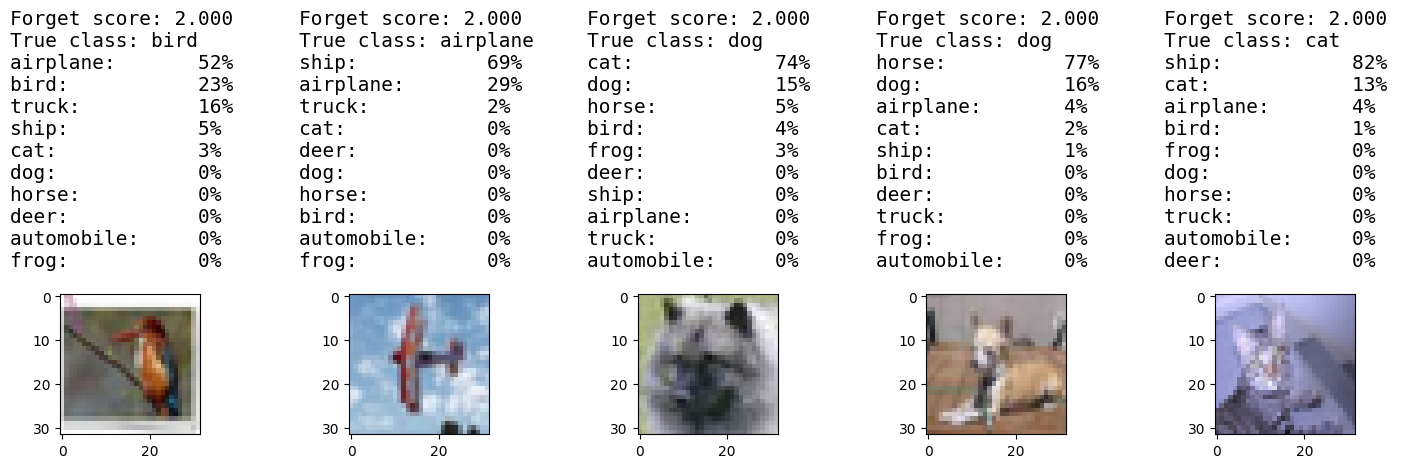

In [9]:
plot_img_and_top(dataset_train_raw, (.98, 1.), true_forget, functional.softmax(scores, dim=1), score_name='Forget')